In [1]:
#Importando bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from optuna import create_study
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
#Importando dados:
features = pd.read_csv("Features selecionadas para treino.csv")
features = features.drop("Unnamed: 0", axis=1)

target = pd.read_csv("Target para treino.csv")
target = target["Class"]
features = features.values

le = LabelEncoder()
target = le.fit_transform(target)

In [3]:
#Otimização de hiperparâmetros:

def instancia_geral(trial, parametros, algoritmo):
    modelo = algoritmo(**parametros)
    return modelo

def objetivo_geral(trial, parametros, algoritmo):
    modelo = instancia_geral(trial, parametros, algoritmo)
    metricas = cross_val_score(
        modelo,
        features,
        target,
        scoring="accuracy",
        cv= 5
    )
    return metricas.mean()


def funcao_objetivo_parcial_nb(trial):
    parametros = {"var_smoothing": trial.suggest_float("var_smoothing", 1e-12, 1.0, log=True)}
    return objetivo_geral(trial, parametros, GaussianNB)

In [4]:
estudo = create_study(
    direction="maximize",
    study_name="NaiveBayes",
    storage=f"sqlite:///NaiveBayes.db",
    load_if_exists=True,
)

estudo.optimize(funcao_objetivo_parcial_nb, n_trials=1000)

[I 2025-10-17 16:15:25,943] A new study created in RDB with name: NaiveBayes
[I 2025-10-17 16:15:26,127] Trial 0 finished with value: 0.7789387755102041 and parameters: {'var_smoothing': 4.1837623087741585e-05}. Best is trial 0 with value: 0.7789387755102041.
[I 2025-10-17 16:15:26,290] Trial 1 finished with value: 0.790938775510204 and parameters: {'var_smoothing': 0.0007716860057834983}. Best is trial 1 with value: 0.790938775510204.
[I 2025-10-17 16:15:26,464] Trial 2 finished with value: 0.7789387755102041 and parameters: {'var_smoothing': 1.0705020826441659e-09}. Best is trial 1 with value: 0.790938775510204.
[I 2025-10-17 16:15:26,626] Trial 3 finished with value: 0.8028571428571428 and parameters: {'var_smoothing': 0.0033019096565445006}. Best is trial 3 with value: 0.8028571428571428.
[I 2025-10-17 16:15:26,792] Trial 4 finished with value: 0.774938775510204 and parameters: {'var_smoothing': 9.990999807127827e-05}. Best is trial 3 with value: 0.8028571428571428.
[I 2025-10-17 1

In [5]:
# Treinando um modelo k-NN com estes parâmetros
params = estudo.best_trial.params

predictor = GaussianNB(**params)
predictor.fit(features, target)

,priors,None
,var_smoothing,0.0034814988212798813


In [6]:
#Importando dados de teste
X = pd.read_csv("Features selecionadas para teste.csv")
X = X.drop("Unnamed: 0", axis=1).values
y_pd = pd.read_csv("Target para teste.csv")
Y = y_pd["Class"]

nle = LabelEncoder()
y = nle.fit_transform(Y)

In [7]:
predictor = GaussianNB(**params)
predictor.fit(features, target)
y_pred = predictor.predict(X)
accuracy = accuracy_score(y, y_pred)
print(accuracy)

y_pred_trans = nle.inverse_transform(y_pred)

0.7738095238095238


['Control' 'Impaired']


<Axes: >

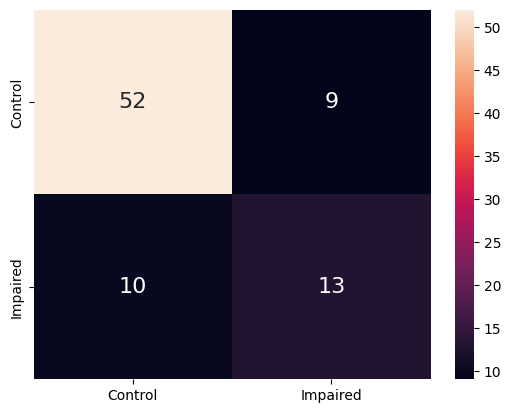

In [8]:
#Montando a matriz de confusão 
classes = np.unique(y_pred_trans)
print(classes)
cm = confusion_matrix(Y, y_pred_trans, labels=classes)
df_conf = pd.DataFrame(cm, classes, classes)
sns.heatmap(df_conf, annot=True, annot_kws={"size": 16})

## Conclusões:
Este modelo teve uma acurácia de 77.4% quando submetido aos dados de teste. Nota-se um viés grande para identificação de indivíduos saudáveis, o que faz o modelo cometer muitos falsos negativos (10 contra 13 acertos). A taxa de acertos de pessoas doentes (quantidade de pessoas doentes previstas/quantidade real de pessoas doentes) é da ordem de 56%, o que torna nosso modelo como incapaz de identificar um paciente com alzheimer com precisão.